### Import

In [1]:
import torch
import numpy as np
import re
from fairseq import utils,tasks
from fairseq import checkpoint_utils
from fairseq import distributed_utils, options, tasks, utils
from fairseq.dataclass.utils import convert_namespace_to_omegaconf
from utils.zero_shot_utils import zero_shot_step
from tasks.mm_tasks.vqa_gen import VqaGenTask
from models.unival import UnIVALModel
from PIL import Image

from matplotlib import pyplot as plt

# turn on cuda if GPU is available
use_cuda = torch.cuda.is_available()
# use fp16 only when GPU is available
use_fp16 = False


In [2]:
# Register VQA task
tasks.register_task('vqa_gen',VqaGenTask)

<function fairseq.tasks.register_task.<locals>.register_task_cls(cls)>

### Load model

In [3]:
# specify some options for evaluation
# checkpoint_path = '/data/mshukor/logs/ofa/best_models/unival_vqa/checkpoint_best.pt'
checkpoint_path = '/data/mshukor/logs/ofa/best_models/unival_s2_hs/checkpoint1.pt'


video_model_path = '/data/mshukor/logs/ofa/best_models/resnext-101-kinetics.pth'
resnet_model_path = '/data/mshukor/logs/ofa/best_models/resnet101-5d3b4d8f.pth'



parser = options.get_generation_parser()
input_args = ["", "--task=vqa_gen", "--beam=100", "--unnormalized", "--path="+checkpoint_path, "--bpe-dir=utils/BPE"]
args = options.parse_args_and_arch(parser, input_args)
cfg = convert_namespace_to_omegaconf(args)

overrides={"video_model_path": video_model_path, "resnet_model_path": resnet_model_path}


In [4]:


# Load pretrained ckpt & config
task = tasks.setup_task(cfg.task)
models, cfg = checkpoint_utils.load_model_ensemble(
    utils.split_paths(cfg.common_eval.path),
    task=task,
    arg_overrides=overrides
)

# Move models to GPU
for model in models:
    model.eval()
    if use_fp16:
        model.half()
    if use_cuda and not cfg.distributed_training.pipeline_model_parallel:
        model.cuda()
    model.prepare_for_inference_(cfg)

# Initialize generator
generator = task.build_generator(models, cfg.generation)

self.sample_patch_num 225
self.sample_audio_patch_num None
self.sample_video_patch_num None
self.with_cls False
Frozen image bn <class 'models.unival.frozen_bn.FrozenBatchNorm2d'>
Frozen video bn <class 'models.unival.frozen_bn.FrozenBatchNorm2d'>
Loading:  all_resnext101
use bn: <class 'models.unival.frozen_bn.FrozenBatchNorm2d'>
load pretrained_model /data/mshukor/logs/ofa/best_models/resnext-101-kinetics.pth
_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.weight', 'fc.bias'])
load resnet /data/mshukor/logs/ofa/best_models/resnet101-5d3b4d8f.pth
<All keys matched successfully>
unival
getattr(args, "stop_on_max_len", False) False


### Preprocess

In [5]:
# Image transform
from torchvision import transforms
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((cfg.task.patch_image_size, cfg.task.patch_image_size), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Text preprocess
bos_item = torch.LongTensor([task.src_dict.bos()])
eos_item = torch.LongTensor([task.src_dict.eos()])
pad_idx = task.src_dict.pad()

# Normalize the question
def pre_question(question, max_ques_words):
    question = question.lower().lstrip(",.!?*#:;~").replace('-', ' ').replace('/', ' ')
    question = re.sub(
        r"\s{2,}",
        ' ',
        question,
    )
    question = question.rstrip('\n')
    question = question.strip(' ')
    # truncate question
    question_words = question.split(' ')
    if len(question_words) > max_ques_words:
        question = ' '.join(question_words[:max_ques_words])
    return question

def encode_text(text, length=None, append_bos=False, append_eos=False):
    s = task.tgt_dict.encode_line(
        line=task.bpe.encode(text),
        add_if_not_exist=False,
        append_eos=False
    ).long()
    if length is not None:
        s = s[:length]
    if append_bos:
        s = torch.cat([bos_item, s])
    if append_eos:
        s = torch.cat([s, eos_item])
    return s

# Construct input for open-domain VQA task
def construct_sample(image: Image, question: str):
    patch_image = patch_resize_transform(image).unsqueeze(0)
    patch_mask = torch.tensor([True])

    question = pre_question(question, task.cfg.max_src_length)
    question = question + '?' if not question.endswith('?') else question
    src_text = encode_text(' {}'.format(question), append_bos=True, append_eos=True).unsqueeze(0)

    src_length = torch.LongTensor([s.ne(pad_idx).long().sum() for s in src_text])
    ref_dict = np.array([{'yes': 1.0}]) # just placeholder
    sample = {
        "id":np.array(['42']),
        "net_input": {
            "src_tokens": src_text,
            "src_lengths": src_length,
            "patch_images": patch_image,
            "patch_masks": patch_mask,
        },
        "ref_dict": ref_dict,
    }
    return sample
  
# Function to turn FP32 to FP16
def apply_half(t):
    if t.dtype is torch.float32:
        return t.to(dtype=torch.half)
    return t

/data/mshukor/envs/ofa/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  
/data/mshukor/envs/ofa/lib/python3.7/site-packages/torchvision/transforms/transforms.py:330: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


### Inference

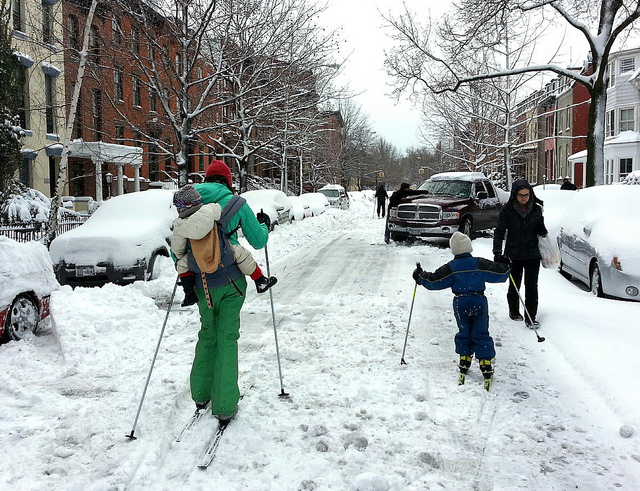

In [6]:
# img_path = '/data/mshukor/data/coco/val2014/COCO_val2014_000000004227.jpg'
# question = "what is the colour of the man's shirt"

# img_path = '/data/mshukor/data/coco/val2014/COCO_val2014_000000004175.jpg'
# question = "how many players are in the court?"

# img_path = '/data/mshukor/data/coco/val2014/COCO_val2014_000000003694.jpg'
# question = "is there a basketball hoop in the image?"


# img_path = '/data/mshukor/data/coco/val2014/COCO_val2014_000000002890.jpg'
# question = "what is the woman wearing black doing?"

# img_path = '/data/mshukor/data/coco/val2014/COCO_val2014_000000002621.jpg'
# question = "what does the street sign say?"


# img_path = '/data/mshukor/data/coco/val2014/COCO_val2014_000000005540.jpg'
# question = "is this a vegetarian plate?"

# img_path = '/data/mshukor/data/coco/val2014/COCO_val2014_000000004975.jpg'
# question = "why the people are happy?"

# img_path = '/data/mshukor/data/coco/val2014/COCO_val2014_000000007816.jpg'
# question = "what is the man doing?"


# img_path = '/data/mshukor/data/coco/val2014/COCO_val2014_000000006748.jpg'
# question = "what is the animal doing?"


# img_path = 'results/images//phone2.png'
# question = "What is on the phone screen?"

# img_path = 'results/images//plate.png'
# question = "What can you see out the window?"


# img_path = 'results/images//driver.png'
# question = "Whom is the person texting?"

# img_path = '/data/mshukor/data/coco/val2014/COCO_val2014_000000003694.jpg'
# question = "how many people are playing basketball?"



## Limitations 
# img_path = 'results/images//driver.png'
# question = "Whom is the person texting?"


# img_path = '/data/mshukor/data/coco/val2014/COCO_val2014_000000002890.jpg'
# question = "Is the woman wearing green happy?"

# img_path = 'results/images//plate.png'
# question = "Where people are eating?"


# instruction following 

# img_path = 'results/images/monaliza.png'
# question = "Do you know who drew this painting?"

# img_path = 'results/images/taxi_car.png'
# # question = "What is unusual about this image?"
# question = "what does the image describe?"


# img_path = 'results/images/nuggets.png'
# question = "what does the image describe?"


img_path = '/data/mshukor/data/coco/val2014/COCO_val2014_000000002890.jpg'
question = "What does the image describe in details?"


image = Image.open(img_path)

sample = construct_sample(image, question)
sample = utils.move_to_cuda(sample) if use_cuda else sample
sample = utils.apply_to_sample(apply_half, sample) if use_fp16 else sample
image

In [7]:
# Run eval step for open-domain VQA
with torch.no_grad():
    result, scores = zero_shot_step(task, generator, models, sample)

What does the image describe in details? a group of people riding skis down a snow covered street


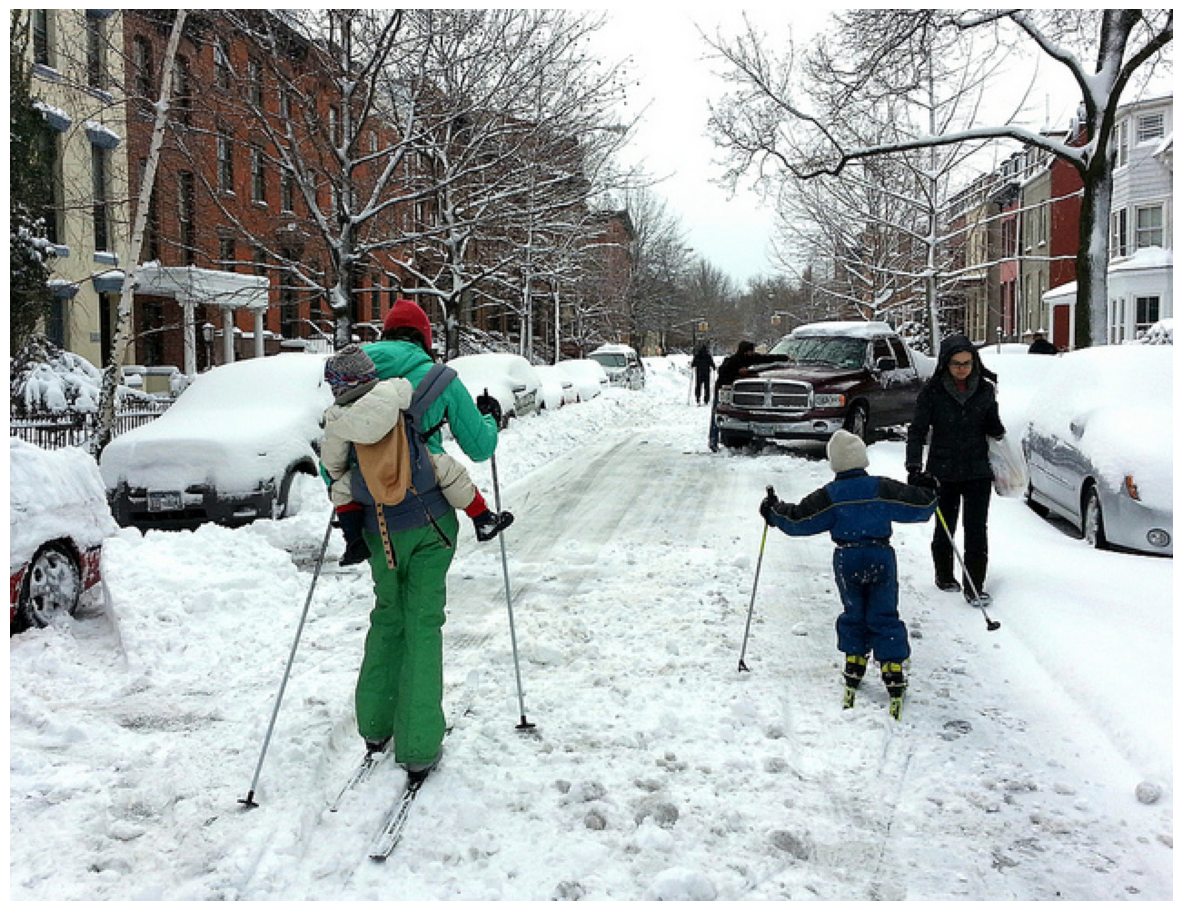

In [8]:
save_dir = '/home/mshukor/ofa_adastra'

text = question+" "+result[0]['answer']
print(text)
plt.figure(figsize=(15, 15))
plt.axis('off')

plt.imshow(image)

save_path = save_dir + '/results/vqa/'+"_".join(text.split(' '))+".jpg"
plt.savefig(save_path, bbox_inches='tight')


plt.show()